# Processing Science Images
## <font color=purple> Scaling and Combining
<font color=purple> Written by Maria Funcich    

### <font color=purple> $\star$ Importing necessary libraries

In [1]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm 
from photutils.centroids import centroid_2dg 
from scipy.ndimage import shift 
from photutils import CircularAperture
from photutils import aperture_photometry
import os

### <font color=purple> $\star$ Collecting and Loading the Shifted Science images

In [2]:
# function 'image_collect' that collects all the images from a specified band // reads .fit in adu
## 2 arguments --> directory: location of the .fit
##             --> band: type of filter

def image_collect(directory, band):
    cwd = os.getcwd()                # saving current directory
    os.chdir(directory)              # changing directory
    images = ccdproc.ImageFileCollection(".", glob_include = band)                 # collects all specified band images in the directory
     
    scim = [CCDData.read(fn, unit = "adu") for fn in images.files_filtered()]      # defines "scim" to read the CCD data in adu
    os.chdir(cwd)                    # returning to the defined current directory
    
    return scim                      # returns (value) array

### <font color=purple> $\star$ Aperture Photometry

In [3]:
# function 'photometry' does photometry aperture on the specified/bright stars // prints out the photometry (flux values) table
## 2 arguments --> star_position: (x,y) coordinates of bright stars
##             --> radius: radius of circular aperture

def photometry(star_position, radius): 
    
    apertures = CircularAperture(star_position, r = radius)       # apertures defined by a circle with radius 'r' pixels that will surround the star
    phot_table = aperture_photometry(scim[0], apertures)          # defining a photometry table that calculates and displays the flux for each star in the first image
    print("\n",
          
          "PHOTOMETRY TABLE FOR FIRST IMAGE",
          
          "\n",
          
          phot_table,
         
         "\n")
    
    phot_table=[]       # creates a new array for all our science image photometry tables
    
    print("\n",
          
          "PHOTOMETRY TABLE FOR ALL IMAGES")
    
    for idx, thisimage in enumerate(scim):                                # for loop that runs through all shifted science images
        phot_table.extend([aperture_photometry(thisimage, apertures)])    # calculates the flux for each star in all science image
        print("\n", 
              
              idx, phot_table[idx], 
              
              "\n")
    
    return phot_table
        
    # printing out flux values in adu for each star in first image 
    print("\n",
          
          "APERTURE SUM OF STARS (Flux Values) FOR FIRST IMAGE",
          
          "\n",
          
          phot_table[0]['aperture_sum'])
    

### <font color=purple> $\star$ Positions of bright stars for B, V, R and I band
<font color=purple> 
- Manually picked in ds9 
 - I picked the stars that would be great for aperture photometry (ones that had a defined circular appearance)
 - Chosen from the first science image
    

In [4]:
# bright stars gathered into an array
## coordinates of stars in the first science image 

position_MAR09_V = [(563.394,321.438), (522.479,299.957), (685.053,46.082), (259.311, 50.565), (185.395,39.328), (408.040,430.484), (415.553, 98.852), (30.863,217.533), (124.637,370.334), (517.631,174.968), (593.371,221.861)]
position_MAR09_B = [(522.664,300.336), (563.243, 321.768), (185.549, 39.929), (441.632, 163.022), (429.312, 327.290), (407.941, 431.066), (429.162,327.251), (226.350,77.914), (239.797,135.189), (259.315,50.801)]  
position_MAR09_R = [(563.794,321.598), (408.146,430.232), (294.930,56.057), (259.531,49.832), (30.926,217.501), (124.916,370.236), (408.212,430.140), (522.99,299.781), (49.627,27.463), (329.471,416.622), (415.754,98.519)]
position_MAR09_I = [(592.363,221.662), (48.246,26.965), (293.889,55.849), (258.523,49.820), (607.125,86.216), (592.409,221.516), (406.849,430.163)]

position_MAR29_V = [(602.816,456.921), (354.656,494.391), (381.877,66.898), (304.334,77.417), (664.473,127.188)]
position_MAR29_R = [(183.279,408.884), (106.253,449.351), (381.617,66.790), (227.294,174.99), (106.054,449.626)]
position_MAR29_I = [(183.558,408.779), (197.279,273.663), (602.400,456.617), (354.483,494.117)]


<font color=purple> 
- The shifted images for the R and I filter are extremely saturated, therefore the flux is most likely going to be an overestimate for those images
- Since I-band stars were saturated, many of the stars nearing the middle of the cluster were merged, therefore must pick more 'isolated' stars to avoid including other stars during aperture photometry 

### <font color=purple> $\star$ Photometry Tables & Cross checking fluxes using best ('most photometric') image

<font color=purple> Cross check by calculating the flux ratio of the first star and the best image
- Where best image also known as our reference image is the best photometric one
 - Stars are well round and well defined 
 - Clear (no blurring)

In [5]:
# function 'cross_check' calculates the flux ratio // reference image over the all science images
## 1 argument --> best image: our reference image

def cross_check(best_image):
    print("\n",
         
         "CROSS CHECKING"
         
         "\n")
    
    for idx, thisimage in enumerate(scim):      # running through all science images
        print("\n",
              
              "Flux ratio of Best Image over Image ",
              
              idx,
              
              "\n")                              # prints the index for each image (0 is the first image in this case)
        
        print(phot_table[best_image]['aperture_sum']/phot_table[idx]['aperture_sum'])                # we use our "best" image as our reference image 
        
        print("\n",
              
              "Median value of Flux across the image:",
              
              "\n",
              
              np.ma.median(phot_table[best_image]['aperture_sum']/phot_table[idx]['aperture_sum']))  # calculates the median value of the flux for each image  
        

In [6]:
# function 'photometry' does photometry aperture on the specified/bright stars // prints out the photometry (flux values) table
## 4 arguments --> directory: location of the .fit
##             --> best_image: reference image
##             --> band: type of filter
##             --> filename: name of final combined image

def scale_and_combine(directory, best_image, band, filename):
    # just changing the directories...
    cwd = os.getcwd()
    os.chdir(directory)
    
    # collecting images...
    images = ccdproc.ImageFileCollection(".",glob_include = band)
    scim = [CCDData.read(fn) for fn in images.files_filtered()]

    ## scaling
    # for loop calculates median flux ratio for each image and displays them
    for idx, thisimage in enumerate(scim): 
        m = np.ma.median(phot_table[best_image]['aperture_sum'] / phot_table[idx]['aperture_sum'])
        print("Image ", idx, ": ", m)                                       # scaling values
        scim[idx] = scim[idx].multiply(m * u.adu)      # implement the scaling (multiplying all science images with the scaled value 'm')

    ## median combine
    #calculates median for the images and combines them
    sci_median = ccdproc.combine(scim, method = 'median',dtype = np.float32, 
                                     minmax_clip = True, minmax_clip_min = -500)
        
    os.chdir(cwd)                     #  return to defined directory 
   
    #sci_median.write(filename)       # writes the median combined image as a .fit
    
    return sci_median
        
    del(scim)

In [7]:
def median_statistics(star_position, radius, best_image):
    apertures = CircularAperture(star_position, r = radius)      
    print('Median combine',
         
         "\n")     
    
    phot_table_median = aperture_photometry(sci_median, apertures)    # calculates and displays flux count for each star       
    print("\n", 'Median pixel value', np.ma.median(sci_median)) # calculates median pixel value in ADU
    print('Standard deviation', np.std(sci_median[400:500,400:500]))  # calculating the standard devitation between 400 to 500 pixels
    
    print("\n",
          
          "PHOTOMETRY TABLE FOR MEDIAN COMBINE IMAGE",
          
          "\n",
          
          phot_table_median,
         
         "\n")      
    
    print("\n",
          
          "Cross Checking: flux ratio with best image",
          
          "\n",
          
        phot_table[best_image]['aperture_sum']/phot_table_median['aperture_sum'],
         
         "\n")   
    
    print("\n",
          
          "Median value of the flux ratio: ",
          
        np.ma.median(phot_table[best_image]['aperture_sum']/phot_table_median['aperture_sum']))  # median value for the flux ratio

### <font color=purple> $\star$ Scaling and Combining each band

### <font color=green> --------------------------------------------------------------------------B-Band---------------------------------------------------------------------------

<font color=purple> **Date:** March 9th | **Exposure Time:** 60.0s

In [8]:
scim = image_collect("../040_shift/data/shifted/march_09_2018","NGC_3201_B*")

phot_table = photometry(position_MAR09_B, 10)

cross_check(6)

sci_median = scale_and_combine("../040_shift/data/shifted/march_09_2018",6,"NGC_3201_B*","NGC_3201_B_median_60.0s.fits")

median_statistics(position_MAR09_B, 10, 6)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

Image  0 :  0.974155776210782
Image  1 :  1.0017954678495578
Image  2 :  0.9916708724243924
Image  3 :  1.007726752467131
Image  4 :  1.0058340914145099
Image  5 :  1.0053249077063695
Image  6 :  1.0
Image  7 :  0.996815271077313
Image  8 :  1.017182002915656
Image  9 :  0.9997202476615366
Image  10 :  0.9745198113454703
Image  11 :  0.9927735599207974
Image  12 :  0.9858996990905458
Image  13 :  0.9985021315248825
Image  14 :  0.9807772317078833
Image  15 :  1.0019858668500257
Median combine 


 Median pixel value -0.23077520728111267
Standard deviation 10.668675

 PHOTOMETRY TABLE FOR MEDIAN COMBINE IMAGE 
  id xcenter ycenter    aperture_sum  
      pix     pix          adu2      
--- ------- ------- -----------------
  1 522.664 300.336 6149.809363802981
  2 563.243 321.768 4804.110507302923
  3 185.549  39.929 11920.41365651146
  4 441.632 163.022 8865.445168952981
  5 429.312  327.29  6784.20306173722
  6 407.941 431.066 6206.831912135498
  7 429.162 327.251 6783.850324494577
  8

<font color=purple>
    
Photometry table for images:
- using a radius of 10 due to the stars having an average value radius below this
- The flux values in ADU for the stars are all consistent across the images

Cross checking:
- Using image 7 as the reference/best image
- An image with a greater flux than our reference image will give us a value less than 1, whereas if it was smaller it would be greater than 1.
- scalar values are all close to 1, this is a good sign

- Median value of the flux ratio:  1.0221964828724026 1 / adu <br>
    
Happy with stack!


### <font color=green> --------------------------------------------------------------------------V-Band---------------------------------------------------------------------------

<font color=purple> **Date:** March 9th | **Exposure Time:** 60.0s

In [9]:
scim = image_collect("../040_shift/data/shifted/march_09_2018","NGC_3201_V*")

phot_table = photometry(position_MAR09_V, 10)

cross_check(12)

sci_median = scale_and_combine("../040_shift/data/shifted/march_09_2018",12,"NGC_3201_V*","NGC_3201_V_median_60.0s.fits")

median_statistics(position_MAR09_V, 10, 12)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

Image  0 :  0.982800668541289
Image  1 :  1.0005169604787933
Image  2 :  1.0070028586716326
Image  3 :  1.0122899512952876
Image  4 :  1.0126433424914878
Image  5 :  1.0078866506845745
Image  6 :  1.0104887631836905
Image  7 :  1.0106417178751366
Image  8 :  0.9921355128627712
Image  9 :  1.0001494786447136
Image  10 :  1.0010571018155012
Image  11 :  1.005441209099103
Image  12 :  1.0
Image  13 :  0.9940725915011813
Image  14 :  1.003370571435326
Image  15 :  1.0017601062072266
Median combine 


 Median pixel value -0.790734052658081
Standard deviation 50.465797

 PHOTOMETRY TABLE FOR MEDIAN COMBINE IMAGE 
  id xcenter ycenter    aperture_sum   
      pix     pix          adu2       
--- ------- ------- ------------------
  1 563.394 321.438 22369.942581790114
  2 522.479 299.957 29233.376587826515
  3 685.053  46.082  4778.992010974711
  4 259.311  50.565 16095.178830298008
  5 185.395  39.328  67771.73038589348
  6  408.04 430.484  30775.74116897171
  7 415.553  98.852 15415.2676062

<font color=purple>
    
Photometry table for images:
- using a radius of 10 due to the stars having an average value radius below this
- The flux values in ADU for the stars are all consistent across the images

Cross checking:
- Using image 13 as the reference/best image
- scalar values are all close to 1, this is a good sign

- Median value of the flux ratio:  1.0152996410680588 1 / adu <br>


<font color=purple> **Date:** March 29th | **Exposure Time:** 30.0s

In [10]:
scim = image_collect("../040_shift/data/shifted/march_29_2018","NGC_3201_V_30*")

phot_table = photometry(position_MAR29_V, 10)

cross_check(0)

sci_median = scale_and_combine("../040_shift/data/shifted/march_29_2018",0,"NGC_3201_V_30*","NGC_3201_V_median_30.0s.fits")

median_statistics(position_MAR29_V, 10, 0)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

 PHOTOMETRY TABLE FOR FIRST IMAGE 
  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 602.816 456.921 32726.209431331776
  2 354.656 494.391   16661.7214099244
  3 381.877  66.898 14352.402681000436
  4 304.334  77.417  5934.319534584272
  5 664.473 127.188  4759.432135554327 


 PHOTOMETRY TABLE FOR ALL IMAGES

 0  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 602.816 456.921 32726.209431331776
  2 354.656 494.391   16661.7214099244
  3 381.877  66.898 14352.402681000436
  4 304.334  77.417  5934.319534584272
  5 664.473 127.188  4759.432135554327 


 1  id xcenter ycenter    aperture_sum   
      pix     pix 

<font color=purple>
Only has 2 images to stack | Photometric night <br>
    
Photometry table for images:
- using a radius of 10 due to the stars having an average value radius below this
- The flux values in ADU for the stars are all consistent across the images

Cross checking:
- Using image 1 as the reference/best image
- scalar values are all close to 1, this is a good sign

- Median value of the flux ratio:  0.9999999982621381 1 / adu <br>


### <font color=green> --------------------------------------------------------------------------R-Band---------------------------------------------------------------------------

<font color=purple> **Date:** March 9th | **Exposure Time:** 60.0s

In [11]:
scim = image_collect("../040_shift/data/shifted/march_09_2018","NGC_3201_R*")

phot_table = photometry(position_MAR09_R, 12)

cross_check(8)

sci_median = scale_and_combine("../040_shift/data/shifted/march_09_2018",8,"NGC_3201_R*","NGC_3201_R_median_60.0s.fits")

median_statistics(position_MAR09_R, 12, 8)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

 0.97757306 0.97259537 0.98286617 1.00827825 0.98757896]

 Median value of Flux across the image: 
 0.9811378302240416

 Flux ratio of Best Image over Image  10 

[0.97300855 0.9741154  1.02667268 0.98609635 0.95702794 0.96510515
 0.97414858 0.97713749 0.9610057  1.02261692 0.98713298]

 Median value of Flux across the image: 
 0.9741485835587208

 Flux ratio of Best Image over Image  11 

[0.99421058 0.98616858 0.99364699 0.99531963 0.98546092 0.96933225
 0.9862194  0.98200972 0.97683023 1.00074565 0.98408628]

 Median value of Flux across the image: 
 0.9861685844086476

 Flux ratio of Best Image over Image  12 

[0.99112408 0.97573978 1.00234257 0.97369292 0.9753417  0.98609811
 0.97563911 0.97345758 0.98574799 0.98909217 0.96990831]

 Median value of Flux across the image: 
 0.9757397801164345

 Flux ratio of Best Image over Image  13 

[0.98364148 0.98062123 0.99281547 0.98663028 0.95941509 0.9876587
 0.98070957 0.97647941 0.97929475 1.01655517 0.9892672 ]

 Median value of Flux a

<font color=purple> **Date:** March 29th | **Exposure Time:** 30.0s

In [12]:
scim = image_collect("../040_shift/data/shifted/march_29_2018","NGC_3201_R_30*")

phot_table = photometry(position_MAR29_R, 12)

cross_check(0)

sci_median = scale_and_combine("../040_shift/data/shifted/march_29_2018",0,"NGC_3201_R_30*","NGC_3201_R_median_30.0s.fits")

median_statistics(position_MAR29_R, 12, 0)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

 PHOTOMETRY TABLE FOR FIRST IMAGE 
  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 183.279 408.884  5111.872869120605
  2 106.253 449.351 4169.3415797833595
  3 381.617   66.79    34507.889097606
  4 227.294  174.99  23966.52959177344
  5 106.054 449.626  4199.150019085888 


 PHOTOMETRY TABLE FOR ALL IMAGES

 0  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 183.279 408.884  5111.872869120605
  2 106.253 449.351 4169.3415797833595
  3 381.617   66.79    34507.889097606
  4 227.294  174.99  23966.52959177344
  5 106.054 449.626  4199.150019085888 


 1  id xcenter ycenter    aperture_sum  
      pix     pix  

### <font color=green> --------------------------------------------------------------------------I-Band---------------------------------------------------------------------------

<font color=purple> **Date:** March 9th | **Exposure Time:** 60.0s

In [13]:
scim = image_collect("../040_shift/data/shifted/march_09_2018","NGC_3201_I*")
phot_table = photometry(position_MAR09_I, 12)
cross_check(9)

sci_median = scale_and_combine("../040_shift/data/shifted/march_09_2018",9,"NGC_3201_I*","NGC_3201_I_median_60.0s.fits")

median_statistics(position_MAR09_I, 12, 9)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

 1.00273526]

 Median value of Flux across the image: 
 0.9991032990811375

 Flux ratio of Best Image over Image  4 

[0.99431503 0.99160303 1.00643026 0.98878738 0.99249105 0.99406229
 1.00546468]

 Median value of Flux across the image: 
 0.9940622870047866

 Flux ratio of Best Image over Image  5 

[1.00982306 0.99765327 0.97388603 1.00041102 0.99075787 1.00949291
 1.00722603]

 Median value of Flux across the image: 
 1.000411016307192

 Flux ratio of Best Image over Image  6 

[1.00562245 0.96334393 0.99395421 0.99792382 0.9880363  1.00521153
 1.00884649]

 Median value of Flux across the image: 
 0.9979238243011309

 Flux ratio of Best Image over Image  7 

[1.00106502 0.96699835 0.9914199  1.00119621 1.02862169 1.0003742
 1.0018293 ]

 Median value of Flux across the image: 
 1.0010650161086194

 Flux ratio of Best Image over Image  8 

[1.00284152 0.9841893  1.00045076 1.00376113 1.03581757 1.00276993
 1.00166551]

 Median value of Flux across the image: 
 1.0027699274514383

 

<font color=purple> **Date:** March 29th | **Exposure Time:** 30.0s

In [14]:
scim = image_collect("../040_shift/data/shifted/march_29_2018","NGC_3201_I_30*")

phot_table = photometry(position_MAR29_I, 12)

cross_check(0)

sci_median = scale_and_combine("../040_shift/data/shifted/march_29_2018",0,"NGC_3201_I_30*","NGC_3201_I_median_30.0s.fits")

median_statistics(position_MAR29_I, 12, 0)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

 PHOTOMETRY TABLE FOR FIRST IMAGE 
  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 183.558 408.779  6523.741985363817
  2 197.279 273.663 11707.725346667197
  3   602.4 456.617 101869.98829378605
  4 354.483 494.117  53573.67858406845 


 PHOTOMETRY TABLE FOR ALL IMAGES

 0  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 183.558 408.779  6523.741985363817
  2 197.279 273.663 11707.725346667197
  3   602.4 456.617 101869.98829378605
  4 354.483 494.117  53573.67858406845 


 1  id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1 183.558 408.77

Best to use Median and not an average combine of an image for this case 

### <font color=purple> $\star$ Displaying and Checking the final scaled and median stacked images

In [15]:
def display(directory, file, vmax_, vmin_, title):              
    cwd = os.getcwd()
    os.chdir(directory)
    image = CCDData.read(file, unit="adu")
    fig, ax = plt.subplots(figsize = (12,7))

    plt.rcParams.update({'font.size':14 })
    plt.imshow(image, cmap='gray', vmax=vmax_, vmin=vmin_)
    plt.xlabel('x-pixels')
    plt.ylabel('y-pixels')
    plt.title(title)
    plt.colorbar()
    os.chdir(cwd)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]


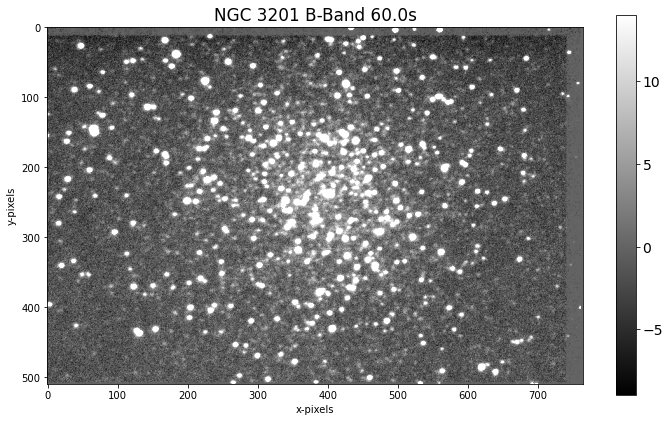

In [16]:
display("march_09_2018_stacked", "NGC_3201_B_median_60.0s.fits", 14, -9, "NGC 3201 B-Band 60.0s")

<font color=purple> Displaying the images using ds9 instead of mayplotlib since images are scaled down and blurry... 
    
- In terminal: "ds9 -zscale NGC_3201*"
    


### <font color=purple> $\star$ NOTES:
    
<font color=purple> 
    
- The 30.0 second exposures from the photometric night (29th of March) only had 2 images to stack (except the B-band which only had 1 - no need to stack...)
    - Out of all the bands, each set always had 1 blurry image <br>
    
    
- The I-band and R-band both have indistguishable stars nearing the centre of the cluster, this is because a lot of the stars ended up merging after stacking...This occured due to the over saturation of the raw images and noticeable shifts. <br>
    
    
- You can notice that each band picked up a lot of faint stars, the noise has also decreased (number of counts per pixel decreases across the background of the image) <br>
    
    
- Best stacked images were from the B and V bands 